# **Image Classification**

<a target="_blank" href="https://github.com/amaciag/CV-Experiments/blob/main/Shampoo_Image_Classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"/>View source on GitHub</a>

Image classification is the supervised learning process of identifying what an image represents.
This tutorial shows how to use transfer learning and data augmentation approaches to train an image classifier on a smaller dataset. 

* Transfer learning is a method that resuses some knowledge learned from a pre-trained model and applies it to a different but related task.
* Data Augmentaion is a technique to add diversity and to increase the size of a training dataset.

## **Import appropriate modules for this tutorial**

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from IPython.display import Javascript
from google.colab import drive

def resize_output_cell():
  display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

get_ipython().events.register('pre_run_cell', resize_output_cell)
drive.mount('/content/drive')

print('Tensoflow Version: ', tf.__version__)

Tensoflow Version:  2.7.0


## **Get shampoo image data**

In [ ]:
# Get shampoo image data
!sudo apt-get install subversion
!svn export https://github.com/amaciag/CV-Experiments/trunk/data --force
!unzip -o data/shampoos.zip -d data

## **Create resuable functions**

In [ ]:
# Augment image data by adding some random rotaion
data_augment = tf.keras.Sequential(
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05, fill_mode='nearest')
)

# Normalize RGB values to the range from 0 to 1 
def normalize(images, labels):
  
  images = images/255.0
  return images, labels

# Create a training or validation dataset
# Get class names
def prepare_dataset(filepath, mode):

  dataset = tf.keras.utils.image_dataset_from_directory(filepath,
                                         validation_split=0.15,
                                         subset=mode,
                                         seed=123,
                                         image_size=(228, 228),
                                         batch_size=3)
  
  class_names = dataset.class_names

  dataset = dataset.map(normalize, num_parallel_calls = tf.data.AUTOTUNE)
  
  if mode == 'training':
    dataset = dataset.map(lambda images, labels: (data_augment(images), labels), num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.repeat(None)

  else:
    dataset = dataset.repeat(1)

  return class_names, dataset.prefetch(buffer_size = tf.data.AUTOTUNE) 

# Plot images and optionally compare them with predictions
def plot_images(ds, model=None):
    
    fig, ax = plt.subplots(len(ds), 3, figsize=(10,10))
    count = 0
    ax = ax.flatten()
    for images, labels in ds:
        # print(count)
        if model is not None:
            predictions = model.predict(images)
            titles = np.argmax(predictions, axis=1)
            colors = np.where(titles==labels.numpy().flatten(), 'blue', 'red')
        else:
            titles = labels.numpy().flatten()
            colors = np.full(3, 'blue')

        for i in range(images.shape[0]):
            ax[count].imshow(images[i])
            ax[count].set_title(class_names[titles[i]], color=colors[i])
            ax[count].xaxis.set_visible(False)
            ax[count].yaxis.set_visible(False)
            count += 1
    plt.show()
        

## **Prepare datasets and plot sample image data**

In [ ]:
class_names, train_ds = prepare_dataset('data/shampoos', 'training')
_, eval_ds = prepare_dataset('data/shampoos', 'validation')

Found 60 files belonging to 3 classes.
Using 51 files for training.


In [ ]:
# Print some labels
for images, labels in train_ds.take(3):
  print(labels)

tf.Tensor([2 0 0], shape=(3,), dtype=int32)


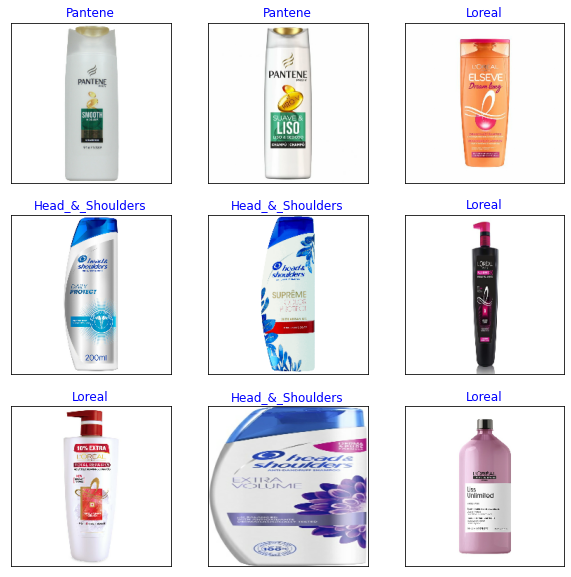

In [ ]:
# Plot some images
plot_images(eval_ds)

## **Build a transfer learning model**

A pre-trained model called Xception is loaded for this tutorial. It is a convolutional nn that contains roughly 71 layers. Since the pre-trained model has been already trained, its weights can be utilized to transform raw input images.

In [ ]:
# Load the Xception pre-trained model without the last layer
# This model will be used as a feature extractor
# Since the feature extractor has been trained, freeze the trainable parameters so that they will not be updated during training

xception_model = tf.keras.applications.Xception(include_top=False, input_shape=(228, 228, 3))
xception_model.trainable = False
xception_model.summary()

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Visualize xception_model

tf.keras.utils.plot_model(xception_model)

In [ ]:
# Add a couple of extra layers on top of the base model
# Parameters in these new layers will be trained to map extracted features to classification results

inputs = tf.keras.Input(shape=(228, 228, 3))
x = xception_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
func_model = tf.keras.Model(inputs, outputs)

func_model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
func_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
___________________________________________

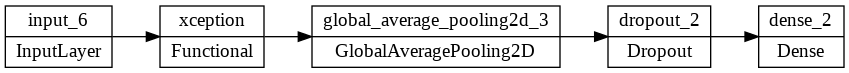

In [ ]:
# Visualize func_model

tf.keras.utils.plot_model(func_model, rankdir='LR')

## **Train the model**

In [ ]:
# Set a small number of training iterations

num_examples = 51
epochs = 15
steps_per_epoch = np.ceil(5*num_examples/(3*epochs))

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]

history = func_model.fit(train_ds, epochs=epochs, 
                         steps_per_epoch=steps_per_epoch, 
                         validation_data=eval_ds)

Epoch 1/15
5/5 [==============================] - 5s 335ms/step - loss: 1.2707 - accuracy: 0.1333 - val_loss: 1.2040 - val_accuracy: 0.4444
Epoch 2/15
5/5 [==============================] - 1s 131ms/step - loss: 0.9387 - accuracy: 0.6667 - val_loss: 1.0970 - val_accuracy: 0.3333
Epoch 3/15
5/5 [==============================] - 0s 93ms/step - loss: 0.9940 - accuracy: 0.5333 - val_loss: 1.0532 - val_accuracy: 0.4444
Epoch 4/15
5/5 [==============================] - 1s 175ms/step - loss: 0.9310 - accuracy: 0.6000 - val_loss: 0.9410 - val_accuracy: 0.5556
Epoch 5/15
5/5 [==============================] - 0s 93ms/step - loss: 0.6875 - accuracy: 0.7333 - val_loss: 0.8732 - val_accuracy: 0.6667
Epoch 6/15
5/5 [==============================] - 1s 121ms/step - loss: 0.6199 - accuracy: 0.9333 - val_loss: 0.8107 - val_accuracy: 0.5556
Epoch 7/15
5/5 [==============================] - 1s 176ms/step - loss: 0.6740 - accuracy: 0.7333 - val_loss: 0.7773 - val_accuracy: 0.6667
Epoch 8/15
5/5 [======

# **Evaluate the model and get predictions**

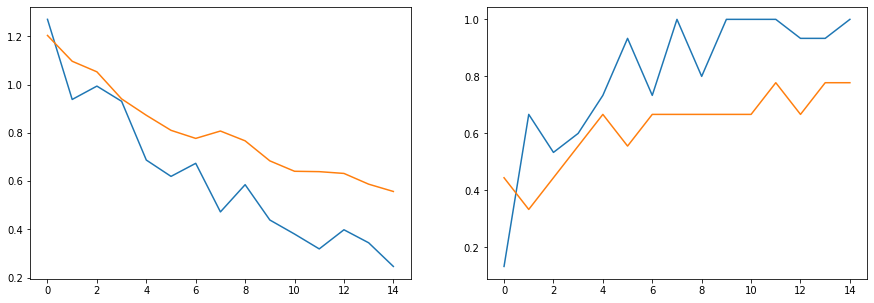

In [ ]:
# Plot model perfomance
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.flatten()
epochs = history.epoch

ax[0].plot(epochs, history.history['loss'], label='training loss')
ax[0].plot(epochs, history.history['val_loss'], label='validation loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(epochs, history.history['accuracy'], label='training accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='validation accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend()

plt.legend()
plt.show()

In [ ]:
# Print metrics
loss, accuracy = func_model.evaluate(eval_ds)
print(f'Loss: {loss}\nAccuracy: {accuracy}')

3/3 [==============================] - 0s 55ms/step - loss: 0.5573 - accuracy: 0.7778


[0.5573426485061646, 0.7777777910232544]

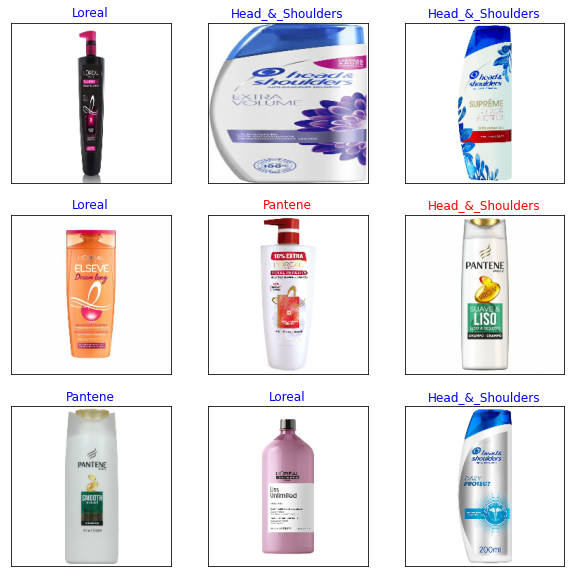

In [ ]:
# Get and check predictions
plot_images(eval_ds, func_model)